In [1]:
import matplotlib.pyplot as plt
from ms2pip.ms2pipC import MS2PIP
import os
import re
import pandas as pd
import numpy as np
from scipy.stats import rankdata, scoreatpercentile
from pyteomics import parser, fasta

In [2]:
input_psm_table = "/mnt/nfs/wangd/project/PXD014145/FDR1/vali_out.tsv"
validate_out = pd.read_table(input_psm_table, header = 0, sep = "\t", index_col=0)

In [ ]:
a = validate_out["spectra_ref"].iloc[0]
print(a)
int(a.split("=")[-1])-1

In [ ]:
validate_out.columns

In [3]:
#Substitution strategy
def replace_mod(s):
    s = s.replace("UNIMOD:4","Carbamidomethyl").replace("UNIMOD:737","TMT6plex").replace("UNIMOD:35","Oxidation").replace("UNIMOD:1","Acetyl").replace("-","|").replace(",","|")
    return s
def get_nativeID(s):
#     return s.split(" ")[-1] 
    return s.split(":")[1]
#     return int(s.split("=")[-1])-1
validate_out.loc[:,"modifications"] = validate_out.apply(lambda x : replace_mod(x["modifications"]) if type(x["modifications"])==str else "-", axis = 1)
validate_out.loc[:,"spec_id"] = validate_out.apply(lambda x : get_nativeID(x["spectra_ref"]), axis = 1)
# validate_out.loc[:,"spec_id"] = validate_out.apply(lambda x : x["PSM_ID"], axis = 1)

In [4]:
all = validate_out[['spec_id', 'sequence', 'modifications',  'charge','retention_time', 'calc_mass_to_charge','search_engine_score[1]']].rename(columns={'sequence': 'peptide', 'retention_time': 'rt', 'calc_mass_to_charge': 'mz','search_engine_score[1]': 'score'})

In [5]:
validate_out[validate_out["SpecFile"]=="MFA380.mzML"][['spec_id', 'sequence', 'modifications',  'charge','retention_time', 'calc_mass_to_charge','search_engine_score[1]']].rename(columns={'sequence': 'peptide', 'retention_time': 'rt', 'calc_mass_to_charge': 'mz','search_engine_score[1]': 'score'})

,spec_id,peptide,modifications,charge,rt,mz,score
48,controllerType=0 controllerNumber=1 scan=310,QCCHTHCTCCR,2|Carbamidomethyl|3|Carbamidomethyl|7|Carbamid...,5,150.800274,316.714613,0.072869
66,controllerType=0 controllerNumber=1 scan=359,TLLPPP,-,2,165.441156,319.199609,0.072869
159,controllerType=0 controllerNumber=1 scan=717,PSCCCCCFYYYCMNG,0|Acetyl|3|Carbamidomethyl|4|Carbamidomethyl|5...,3,272.943450,715.224975,0.072869
276,controllerType=0 controllerNumber=1 scan=1155,KKKFLLK,-,2,403.166880,452.820757,0.072869
277,controllerType=0 controllerNumber=1 scan=1155,KKKFLLK,-,2,403.166880,452.820757,0.072869
...,...,...,...,...,...,...,...
101729,controllerType=0 controllerNumber=1 scan=27290,YDCGEEILITVLSAMTEEAAVAIK,0|TMT6plex|3|Carbamidomethyl|15|Oxidation|24|T...,4,4426.100000,775.910414,0.000049
101730,controllerType=0 controllerNumber=1 scan=28248,YDCGEEILITVLSAMTEEAAVAIK,0|TMT6plex|3|Carbamidomethyl|24|TMT6plex,3,4574.400000,1028.879822,0.000049
101731,controllerType=0 controllerNumber=1 scan=20187,YVELFLNSTAGASGGAYEHR,0|TMT6plex,3,3349.600000,791.067518,0.000018
101732,controllerType=0 controllerNumber=1 scan=20462,YVELFLNSTAGASGGAYEHR,0|TMT6plex,3,3391.100000,791.067518,0.000018


In [7]:
all.to_csv('/mnt/nfs/wangd/ms2pip/all.peprec', sep=' ', index=False)

In [8]:
for i in range(380,392):
    mfa = validate_out[validate_out["SpecFile"]=="MFA"+str(i)+".mzML"]
    mfa = mfa[['spec_id', 'sequence', 'modifications',  'charge','retention_time', 'calc_mass_to_charge','search_engine_score[1]']].rename(columns={'sequence': 'peptide', 'retention_time': 'rt', 'calc_mass_to_charge': 'mz','search_engine_score[1]': 'score'})
    mfa.to_csv('/mnt/nfs/wangd/ms2pip/'+str(i)+ '.peprec', sep=' ', index=False)

In [9]:
params = {
     "ms2pip": {
         "ptm": [
             "Carbamidomethyl,57.021464,opt,C",
             "TMT6plex,229.162932,opt,K",
             "TMT6plex,229.162932,opt,N-term",
             "Oxidation,15.994915,opt,M",
             "Acetyl,42.010565,opt,N-term",
         ],
         "model": "HCD2019",
         "frag_method": "HCD",
         "frag_error": 0.01,
         "out": "csv",
         "sptm": [], "gptm": [],
     }
}

In [10]:
for i in range(380,392):
    ms2pip = MS2PIP("/mnt/nfs/wangd/ms2pip/"+str(i)+".peprec", spec_file="/mnt/nfs/wangd/project/PXD014145/MFA"+str(i)+".mzML",params=params, num_cpu=48, compute_correlations=True, output_filename="/mnt/nfs/wangd/ms2pip/"+str(i))
    ms2pip.run()

In [11]:
results = []
for i in range(380,392):
    r = pd.read_csv("/mnt/nfs/wangd/ms2pip/"+str(i)+"_correlations.csv", index_col=0)
    r['percentile'] = rankdata(r.pearsonr) / r.shape[0]
    results.append(r)
result = pd.concat(results)

In [14]:
result

,spec_id,ion,pearsonr,percentile
0,controllerType=0 controllerNumber=1 scan=10004,B,-0.588259,0.002716
1,controllerType=0 controllerNumber=1 scan=10004,Y,0.520719,0.557692
2,controllerType=0 controllerNumber=1 scan=10014,B,0.883562,0.874891
3,controllerType=0 controllerNumber=1 scan=10014,Y,NaN,0.965613
4,controllerType=0 controllerNumber=1 scan=10015,B,0.314729,0.374946
...,...,...,...,...
17491,controllerType=0 controllerNumber=1 scan=9997,Y,0.383532,0.438557
17492,controllerType=0 controllerNumber=1 scan=9998,B,0.581776,0.603395
17493,controllerType=0 controllerNumber=1 scan=9998,Y,0.914894,0.904321
17494,controllerType=0 controllerNumber=1 scan=9999,B,0.117596,0.184042


In [15]:
all

,spec_id,peptide,modifications,charge,rt,mz,score
0,controllerType=0 controllerNumber=1 scan=33,TRQCFCDGCC,4|Carbamidomethyl|6|Carbamidomethyl|9|Carbamid...,2,68.097480,682.235953,0.072869
1,controllerType=0 controllerNumber=1 scan=4,VHILIL,0|TMT6plex,2,61.140018,468.825817,0.072869
2,controllerType=0 controllerNumber=1 scan=4,VHILIL,0|TMT6plex,2,61.140018,468.825817,0.072869
3,controllerType=0 controllerNumber=1 scan=4,VHILIL,0|TMT6plex,2,61.140018,468.825817,0.072869
4,controllerType=0 controllerNumber=1 scan=4,VHILIL,0|TMT6plex,2,61.140018,468.825817,0.072869
...,...,...,...,...,...,...,...
106965,controllerType=0 controllerNumber=1 scan=17411,WQTMIEAHVDVK,0|TMT6plex|12|TMT6plex,3,3086.300000,639.021912,0.000049
106966,controllerType=0 controllerNumber=1 scan=17392,YGSDIVPFSK,0|TMT6plex|10|TMT6plex,2,3083.300000,785.947700,0.000049
106967,controllerType=0 controllerNumber=1 scan=20954,YVAVMPPHIGDQPLTGAYTVTLDGR,0|TMT6plex,3,3621.500000,967.510782,0.000018
106968,controllerType=0 controllerNumber=1 scan=26361,TALLDAAGVASLLTTAEVVVTEIPK,25|TMT6plex,3,4441.900000,904.526316,0.000018


In [16]:
df = pd.merge(all, result, on='spec_id')

In [17]:
df

,spec_id,peptide,modifications,charge,rt,mz,score,ion,pearsonr,percentile
0,controllerType=0 controllerNumber=1 scan=33,TRQCFCDGCC,4|Carbamidomethyl|6|Carbamidomethyl|9|Carbamid...,2,68.097480,682.235953,0.072869,B,NaN,0.978847
1,controllerType=0 controllerNumber=1 scan=33,TRQCFCDGCC,4|Carbamidomethyl|6|Carbamidomethyl|9|Carbamid...,2,68.097480,682.235953,0.072869,Y,NaN,0.978897
2,controllerType=0 controllerNumber=1 scan=4,VHILIL,0|TMT6plex,2,61.140018,468.825817,0.072869,B,NaN,0.999301
3,controllerType=0 controllerNumber=1 scan=4,VHILIL,0|TMT6plex,2,61.140018,468.825817,0.072869,Y,NaN,0.998656
4,controllerType=0 controllerNumber=1 scan=4,VHILIL,0|TMT6plex,2,61.140018,468.825817,0.072869,B,NaN,0.999301
...,...,...,...,...,...,...,...,...,...,...
1050145,controllerType=0 controllerNumber=1 scan=3332,KMKKKK,-,2,849.575100,395.770210,0.072869,Y,NaN,0.971765
1050146,controllerType=0 controllerNumber=1 scan=4775,HTGAVLK,0|TMT6plex|7|TMT6plex,3,1122.000000,395.256957,0.000193,B,0.587064,0.607396
1050147,controllerType=0 controllerNumber=1 scan=4775,HTGAVLK,0|TMT6plex|7|TMT6plex,3,1122.000000,395.256957,0.000193,Y,0.751642,0.762403
1050148,controllerType=0 controllerNumber=1 scan=3497,SVSSSSYR,0|TMT6plex,2,876.900000,551.290525,0.000184,B,-0.188457,0.040866


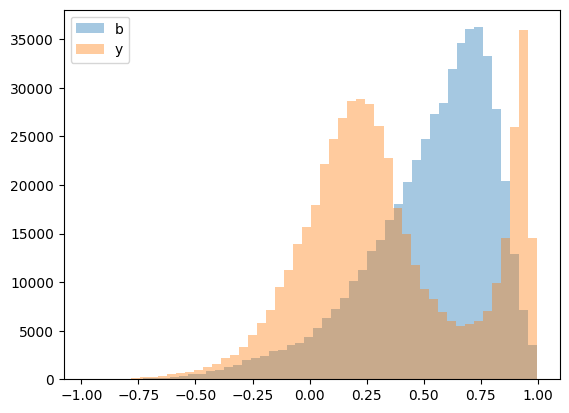

In [18]:
plt.hist(df.loc[df.ion == 'B', 'pearsonr'], bins=50, alpha=0.4, label='b')
plt.hist(df.loc[df.ion == 'Y', 'pearsonr'], bins=50, alpha=0.4, label='y')
plt.legend()

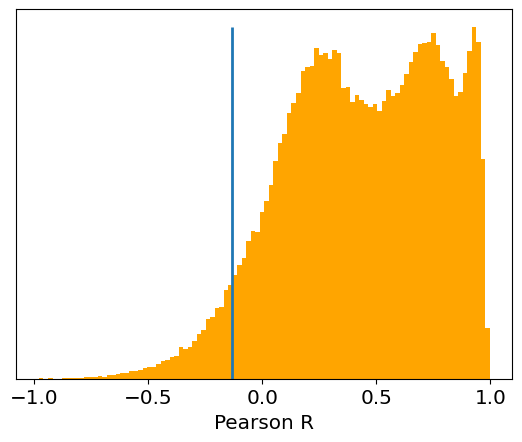

In [19]:
y, x, _ = plt.hist(df['pearsonr'], bins=100, color='orange')
plt.vlines(scoreatpercentile(df['pearsonr'], 5), 0, y.max(), lw=2)
plt.xlabel('Pearson R', fontsize='x-large')
plt.xticks(np.linspace(-1, 1, 5), fontsize='x-large')
plt.gca().get_yaxis().set_visible(False)

plt.savefig('pearsonr_hist.svg')